In [2]:
from pymongo import MongoClient
import pandas as pd

client = MongoClient("mongodb://localhost:27017/") # Hosted with Docker

db = client["rightmove"]

# Access collection
collection = db["properties"]

fields = {"propertyImages": 1, "id": 1}
query = {}

# Fetch data from the collection
data = collection.find(query, fields)

# Convert to Pandas DataFrame
df = pd.DataFrame(list(data))

In [5]:
df.head()

,_id,id,propertyImages
0,656dfa586037a12e52f660b6,142473758,{'images': [{'srcUrl': 'https://media.rightmov...
1,656dfa586037a12e52f660b7,86375754,{'images': [{'srcUrl': 'https://media.rightmov...
2,656dfa586037a12e52f660b8,141848477,{'images': [{'srcUrl': 'https://media.rightmov...
3,656dfa586037a12e52f660b9,142066406,{'images': [{'srcUrl': 'https://media.rightmov...
4,656dfa586037a12e52f660ba,142557041,{'images': [{'srcUrl': 'https://media.rightmov...


## Fetch Image

In [4]:
import requests
from PIL import Image
from io import BytesIO

In [6]:
property = df.iloc[0]

In [10]:
images_list = property['propertyImages']['images']

In [11]:
image = images_list[0]

In [13]:
response = requests.get(image['srcUrl'])

In [14]:
if response.status_code == 200:
    # Open the image from the bytes in memory
    image = Image.open(BytesIO(response.content))

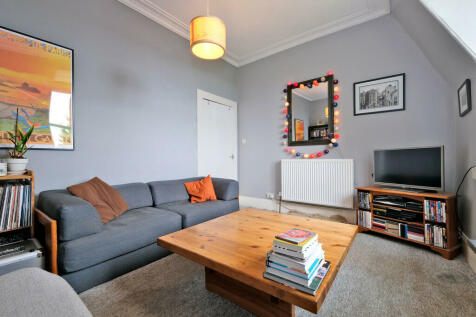

In [15]:
image

# Zero-shot object detection with Hugging Face

In [17]:
from transformers import pipeline

checkpoint = "openai/clip-vit-large-patch14"
detector = pipeline(model=checkpoint, task="zero-shot-image-classification")

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor confi

In [39]:
predictions = detector(
    image,
    candidate_labels=["bathroom", "bedroom", "living room", "kitchen"],
)

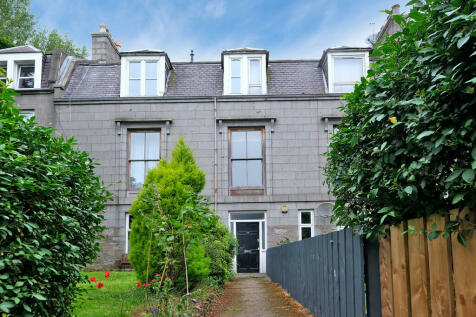

In [40]:
image

In [41]:
predictions

[{'score': 0.7486562728881836, 'label': 'bedroom'},
 {'score': 0.13610100746154785, 'label': 'living room'},
 {'score': 0.09482002258300781, 'label': 'kitchen'},
 {'score': 0.020422793924808502, 'label': 'bathroom'}]

## Label every image

In [23]:
image_urls = [image['srcUrl'] for image in images_list]

In [25]:
import os 

save_dir = 'images'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

for url in image_urls:
    try:
        response = requests.get(url, timeout=10)
        if response.status_code == 200:
            image = Image.open(BytesIO(response.content))
            file_name = os.path.join(save_dir, url.split('/')[-1])
            image.save(file_name)
        else:
            print(f"Failed to download {url}. Status code: {response.status_code}")
    except requests.RequestException as e:
        print(f"Error downloading {url}: {e}")

In [26]:
from transformers import AutoProcessor, AutoModelForZeroShotImageClassification

model = AutoModelForZeroShotImageClassification.from_pretrained(checkpoint)
processor = AutoProcessor.from_pretrained(checkpoint)

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


In [ ]:
candidate_labels = ["bathroom", "bedroom", "living room", "kitchen"]
inputs = processor(images=image, text=candidate_labels, return_tensors="pt", padding=True)

# Clustering

In [42]:
from transformers import AutoImageProcessor, AutoModel


model_ckpt = "nateraw/vit-base-beans"
processor = AutoImageProcessor.from_pretrained(model_ckpt)
model = AutoModel.from_pretrained(model_ckpt)

preprocessor_config.json:   0%|          | 0.00/228 [00:00<?, ?B/s]

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


config.json:   0%|          | 0.00/756 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/343M [00:00<?, ?B/s]

Some weights of ViTModel were not initialized from the model checkpoint at nateraw/vit-base-beans and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [43]:
import torch 

def extract_embeddings(model: torch.nn.Module):
    """Utility to compute embeddings."""
    device = model.device

    def pp(batch):
        images = batch["image"]
        # `transformation_chain` is a compostion of preprocessing
        # transformations we apply to the input images to prepare them
        # for the model. For more details, check out the accompanying Colab Notebook.
        image_batch_transformed = torch.stack(
            [transformation_chain(image) for image in images]
        )
        new_batch = {"pixel_values": image_batch_transformed.to(device)}
        with torch.no_grad():
            embeddings = model(**new_batch).last_hidden_state[:, 0].cpu()
        return {"embeddings": embeddings}

    return pp

In [55]:
def load_images_from_folder(folder, batch_size=32):
    """Load images from a folder and yield batches."""
    images = []
    filenames = os.listdir(folder)
    for filename in filenames:
        if ".jpeg" in filename:
            img = Image.open(os.path.join(folder, filename)).convert('RGB')
            images.append(img)
            if len(images) == batch_size:
                yield images
                images = []
    if images:  # Handle the last batch
        yield images

In [51]:
images = load_images_from_folder("images")

In [57]:
extractor = extract_embeddings(model)

In [59]:
from torchvision import transforms

# Define your transformation chain here
transformation_chain = transforms.Compose([
    transforms.Resize((224, 224)),  # Example resize to 224x224
    transforms.ToTensor(),          # Convert to tensor
    # Add any additional necessary transformations here
])

In [60]:
folder = "images"
for batch in load_images_from_folder(folder):
    batch_dict = {'image': batch}
    embeddings = extractor(batch_dict)['embeddings']

In [62]:
len(embeddings)

17

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
extract_fn = extract_embeddings(model.to(device))
candidate_subset_emb = candidate_subset.map(extract_fn, batched=True, batch_size=batch_size)


In [45]:
num_samples = 100
seed = 42
candidate_subset = dataset["train"].shuffle(seed=seed).select(range(num_samples))

In [49]:
candidate_subset

Dataset({
    features: ['image_file_path', 'image', 'labels'],
    num_rows: 100
})